### Ce notebook traite les données de comptage de trafic de Montpellier Métropole
et 
 in : https://data.montpellier3m.fr/dataset/comptage-vehicules-particuliers-de-montpellier    
 out : GeoJSON des comptages MJA jo et tcj par année, plus une comptage donnant le débit journalier maximum atteint 
 

## 0. initialisations

In [1]:
# pipeline parameters (values will be replaced by papermill when you run the compute.sh script in a docker container, or launch the pipeline)
# the parameters below are used when you test the notebook on jupyter 
# because this cell has a tag "parameters" https://papermill.readthedocs.io/en/latest/usage-parameterize.html
# you will have to download the data beforehand in the directories 
# pour ce notebook on n'utilise pas download.sh ne fait rien, on télécharge les données dans le notebook
# donc SOURCE_DIR ne sert à rien mais il faut que le directory indiqué existe sinon le pipeline plante.
PARAMETER_PROFILE_FILE="../3Mdata/3M.json"
SOURCE_DIR = "../3Mdata"
TARGET_DIR = "../3Mdata/trafic"
debug=False

In [2]:
import sys
import logging
logger = logging.getLogger(__name__)
logging.basicConfig(format="%(levelname)s:%(name)s:%(asctime)s:%(message)s",level=logging.WARNING,stream=sys.stdout)
# Use stderr if script outputs data to stdout.

In [3]:
from pathlib import Path
import json

import pandas as pd
import numpy as np
import geopandas as gpd
#import matplotlib

# choix de la lib gtfs_kit, peut être moins performante que partridge mais maintenue semble-t-il
import gtfs_kit as gk


/home/patgendre/windows/Users/pmgen/Documents/infomobi/essais/tomm/comptages_3M/.venv/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [4]:

import shapely

gpd.options.use_pygeos = True
from pygeos.io import from_wkt

if debug:
    import folium


/home/patgendre/windows/Users/pmgen/Documents/infomobi/essais/tomm/comptages_3M/.venv/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


## 1. lecture des fichiers de comptage routier
URL en dur pour l'instant, sans fichier de paramètres

In [5]:
# load parameters from parameter profile file
#with open(PARAMETER_PROFILE_FILE, 'rt', encoding='UTF-8') as fd:
#    indicator_parameters = json.load(fd)
#GTFS_URL = indicator_parameters.get("GTFS")

In [6]:
COMPTAGES_URL="https://data.montpellier3m.fr/sites/default/files/ressources/MMM_MTP_Comptage.csv"
FILAIRE_URL="https://data.montpellier3m.fr/sites/default/files/ressources/OSM_MMM_CorrespondanceFilaire.geojson"

In [11]:


COMPTAGES = pd.read_csv(COMPTAGES_URL)

## 1.1. lecture des données de COMPTAGES, extraction des MJA sens cumulés par année
https://r4ds.had.co.nz/tidy-data.html
    Each variable must have its own column.
    Each observation must have its own row.
    Each value must have its own cell.

In [8]:
#COMPTAGES.shape
# 9552 lignes COMPTAGES
#COMPTAGES[COMPTAGES['libelle_groupage']=='Sens cumulés'].shape
#2409 lignes concernent des chiffres en sens cumulés
# mais en fait on veut aussi les libelle_groupage des voies en sens unique

In [12]:
# corrections d'erreurs typo
COMPTAGES['libelle_groupage'][(COMPTAGES['libelle_groupage']=="Sens Cumule") | (COMPTAGES['libelle_groupage']=="Sens Cumulé")]="Sens cumulés"

/tmp/ipykernel_67937/2801817833.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  COMPTAGES['libelle_groupage'][(COMPTAGES['libelle_groupage']=="Sens Cumule") | (COMPTAGES['libelle_groupage']=="Sens Cumulé")]="Sens cumulés"


In [10]:
# nettoyage des données : on ne garde que les valeurs de code_centrale qui sont des entiers (et peuvent donc correspondre à un gid de tronçon)
# les autres valeurs sont "test", etc. : on en trouve 19, on en les enlève de notre traitement
COMPTAGES['code_centrale']=COMPTAGES['code_centrale'].apply(lambda x: int(x) if x.isdigit() else "texte")
# il reste 9231 lignes sur 9552 (et 321 'texte')

## A VERIFIER : parmi les code_centrale qui ne sont pas des entiers gid, certains sont en fait des "gid"+lettre,
#par exemple la lettre est 'V' (pour vélo?)


In [11]:
COMPTAGES=COMPTAGES[COMPTAGES['code_centrale']!='texte']

In [12]:
#ll=COMPTAGES.groupby('code_centrale')['libelle_groupage'].apply(set).apply(lambda x: len(x)).to_list()
#from collections import Counter
#Counter(ll).items()

In [132]:
#COMPTAGES['libelle_groupage'].isna().sum()


30

In [117]:
#len(ll)

1513

In [12]:
liste_libelles=COMPTAGES.groupby('code_centrale').agg({"libelle_groupage": set,"objectid": list})
# pour chaque code_centrale, ensemble des valeurs de libellé et liste des id correspondants
# on veut ajouter aux mesures de libellé "sens cumulés" celle qui n'ont qu'une valeur de libellé, et qui correspondent à un sens unique en principe
liste_libelles["nb_libellés"]=liste_libelles['libelle_groupage'].apply(lambda x: len(x))
liste_id=liste_libelles[liste_libelles.nb_libellés==1].objectid.sum()

In [147]:
#for x in COMPTAGES.groupby('code_centrale')['libelle_groupage'].apply(set).apply(lambda x: list(x)).to_list():
#    if len(x)==1:
#        if (x[0][0:4]).lower()=="sens":
#            print(x)

['Sens Cumule']
['Sens cumulés']
['Sens Cumulé']
['Sens cumulés']
['Sens cumulés']
['Sens cumulés']


In [204]:
#COMPTAGES[(COMPTAGES['code_canal']=='Z') & (COMPTAGES['libelle_groupage']=='Sens cumulés')

In [9]:
#COMPTAGES.columns

In [205]:
#code_centrale=list(COMPTAGES.code_centrale)
#id_centrale=list(COMPTAGES.id_centrale)
#code_canal=list(COMPTAGES.code_canal)
#horodate=list(COMPTAGES.horodate)
#descriptif_periode=list(COMPTAGES.descriptif_periode)

In [11]:
#len(set(code_centrale))
#len(set(code_canal))
#len(set(horodate))
#len(set(descriptif_periode))
#len(set(id_centrale))
# 1513 valeurs de code_centrale, 1511 valeurs de id_centrale... 9552 lignes
# 10 valeurs de code_canal, 0 à 8 + Z pour sens cumulés
# 2203 horodates, 1853 descriptif période


In [12]:
#import matplotlib
#from matplotlib import pyplot

In [212]:
#(COMPTAGES['objectid'].isin(liste_id)).sum()

614

In [13]:
# on ne garde que le cumul des comptages dans les 2 sens ou les comptages détectés ci-dessus comme correspondant à un tronçon en sens unique
# soit 2996 lignes sur 9231
QT=COMPTAGES[(COMPTAGES['libelle_groupage']=='Sens cumulés') | (COMPTAGES['objectid'].isin(liste_id))][['nom_voie','code_centrale','horodate','annee','descriptif_periode','mja_jo','mja_tcj']]

In [14]:
QTpm=QT.groupby(['code_centrale','annee']).mean().reset_index()
# on fait la moyenne des comptages existants pour chaque année

In [15]:
QTpm['annee']=pd.to_datetime(QTpm.annee,format="%Y")
# 2419 lignes

In [16]:
#QTpm[['mja_jo','code_centrale','annee']].pivot(index=['annee'],columns=['code_centrale']).plot(legend=False)

In [251]:
#QTpm a 2419 lignes, annee de 2012 à 2022, 2 colonnes mjo jo et tcj
# len(QTpm['code_centrale'].unique())  # 1455 code centrale différents avec des données annuelles sous sens cumulés, contre 1513 au total
# on enlève les années 2012 à 2015 car sont uniquement sur la Ville de Montpellier et pas pertinentes pour ce projet

In [16]:
QTpm['an']=QTpm.annee.apply(lambda x: str(x)[0:4])

In [17]:
# on enlève les données antèrieures à 2016
# il reste 1498 lignes (vs. 1944 lignes au total)
QTpm=QTpm[QTpm["an"]>"2015"]

In [18]:
# on réorganise la donnée pour avoir une colonne par année
QTpman=QTpm.pivot_table(index=['code_centrale'],columns=['an'], values=['mja_jo','mja_tcj'])

In [19]:
QTpman.columns =QTpman.columns.map('_'.join)

In [20]:
QTpman=QTpman.reset_index()

In [21]:
import statistics
QTpman['mja_m']=QTpman.apply(lambda x: np.nanmax([x.mja_jo_2016,x.mja_jo_2017,x.mja_jo_2018,x.mja_jo_2019,x.mja_jo_2020,x.mja_jo_2021,x.mja_jo_2022])
                            , axis=1)

/tmp/ipykernel_66648/393244015.py:2: RuntimeWarning: All-NaN axis encountered
  QTpman['mja_m']=QTpman.apply(lambda x: np.nanmax([x.mja_jo_2016,x.mja_jo_2017,x.mja_jo_2018,x.mja_jo_2019,x.mja_jo_2020,x.mja_jo_2021,x.mja_jo_2022])


In [44]:
# calculer la différence relative entre la mediane de 2016 à 2018
# et la mediane de 2019, 2021, 2022 (2020 est atypique)
QTpman['diffrel']=QTpman.apply(lambda x: 100.0*2.0*(np.nanmedian([x.mja_jo_2019,x.mja_jo_2021,x.mja_jo_2022])- np.nanmedian([x.mja_jo_2016,x.mja_jo_2017,x.mja_jo_2018]))/
               (np.nanmedian([x.mja_jo_2019,x.mja_jo_2021,x.mja_jo_2022])+ np.nanmedian([x.mja_jo_2016,x.mja_jo_2017,x.mja_jo_2018])), axis=1)

/home/patgendre/windows/Users/pmgen/Documents/infomobi/essais/tomm/comptages_3M/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


In [262]:
# 1115 lignes (code_centrales)

1115

In [35]:
#T[T.notna()]

1       41.721133
5        3.728758
20      -4.986080
27     -30.836412
29     -34.350489
          ...    
1078    -6.705591
1085   -19.344783
1086   -15.121632
1094     2.776619
1117   -14.489166
Length: 148, dtype: float64

In [263]:
#QTpman[QTpman.mja_m>50000]

code_centrale  mja_jo_2016  mja_jo_2017  mja_jo_2018  mja_jo_2019  \
57            4032          NaN      71262.0      69546.0      72937.0   
488          42210      30478.0      37031.0      38225.0      32573.0   
499          43268      57412.0      66795.0      65427.0      68613.0   
959         145411          NaN          NaN          NaN          NaN   

     mja_jo_2020  mja_jo_2021  mja_jo_2022  mja_tcj_2016  mja_tcj_2017  \
57       59850.0      68282.0      60710.0           NaN       66469.0   
488      27589.0      51123.0      33545.0       28997.0       34909.0   
499      55752.0      64045.0      58049.0       54603.0       60460.0   
959       6725.0      55103.0      45343.0           NaN           NaN   

     mja_tcj_2018  mja_tcj_2019  mja_tcj_2020  mja_tcj_2021  mja_tcj_2022  \
57        65440.0       68061.0       54930.0       63627.0       55150.0   
488       36115.0       30891.0       25539.0       49322.0       30169.0   
499       60659.0       62683.0       50155.0       58543.0       51446.0   
959           NaN           NaN        6590.0       64921.0       43267.0   

       mja_m   diffrel  
57   72937.0 -3.060150  
488  51123.0 -9.878712  
499  68613.0 -2.134825  
959  55103.0       NaN

## 1.2. lecture du filaire de voirie, association aux comptages

In [22]:
FILAIRE=gpd.read_file(FILAIRE_URL)

In [265]:
#FILAIRE

In [23]:
QTpman=QTpman.rename(columns={'code_centrale': 'gid'})

In [45]:
comptages_an = FILAIRE[['gid','name','one_way','lanes','maxspeed','nom_commun','st_length_','geometry']].merge(QTpman, on='gid')

In [269]:
#comptages_an.columns

Index(['gid', 'name', 'one_way', 'lanes', 'maxspeed', 'nom_commun',
       'st_length_', 'geometry', 'mja_jo_2016', 'mja_jo_2017', 'mja_jo_2018',
       'mja_jo_2019', 'mja_jo_2020', 'mja_jo_2021', 'mja_jo_2022',
       'mja_tcj_2016', 'mja_tcj_2017', 'mja_tcj_2018', 'mja_tcj_2019',
       'mja_tcj_2020', 'mja_tcj_2021', 'mja_tcj_2022', 'mja_m', 'diffrel'],
      dtype='object')

In [50]:
#g=comptages_an.geometry.iloc[30]

In [46]:
# les tronçons de voirie (contenus dans geometry) sont des multilinestrings shapely, avec un seul linestring
def milieu(ls):
    l=list(ls.coords)
    return shapely.geometry.Point(l[int(len(l)/2)][0],l[int(len(l)/2)][1])

In [26]:
# la colonne point_mesure définit la position x,y du "milieu" du tronçon (au sens du point intermédiaire dans la liste des points qui définit le tronçon
#, pas forcément le vrai milieu en abscisse linéaire sur le tronçon)
comptages_an['point_mesure']=comptages_an.apply(lambda x: milieu(x.geometry[0]),axis=1)

In [58]:
#PM=gpd.GeoDataFrame(comptages_an[['point_mesure']],geometry='point_mesure')

<AxesSubplot:>

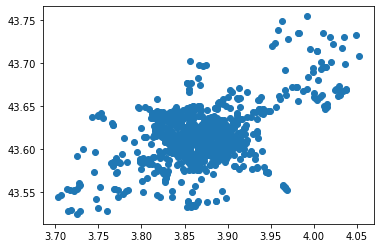

In [59]:
#PM.plot()

<AxesSubplot:>

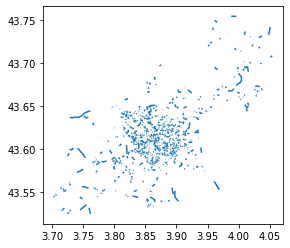

In [274]:
#comptages_an.plot()

In [22]:
#QT[['code_centrale','mja_jo']].plot(x=QT['code_centrale'])

## 1.3 représentation carto (couleur, épaisseur de trait)

In [27]:
comptages_an.to_crs('EPSG:2154',inplace=True)


In [28]:
comptages_an=comptages_an.to_crs('EPSG:2154')  # lambert 93 en mètres


In [29]:
comptages_an['point_mesure']=gpd.GeoSeries(data=comptages_an.point_mesure)

In [30]:
comptages_an['point_mesure']=comptages_an['point_mesure'].set_crs('EPSG:4326') 

In [31]:
comptages_an['point_mesure']=comptages_an['point_mesure'].to_crs('EPSG:2154')  # lambert 93 en mètres

In [32]:
comptages_an['troncon']=comptages_an.apply(lambda x: x['geometry'].buffer(max(10.0,200.0*x['mja_m']/100000)) , axis=1)
# épaisseur du tronçon selon le trafic : 200 mètres pour 100k vh/j

In [33]:
comptages_an['debit']=comptages_an.apply(lambda x: x['point_mesure'].buffer(max(10.0,200.0*x['mja_m']/100000)) , axis=1)
# rayon du disque selon le débit/trafic : 200 mètres pour 100k vh/j

In [34]:
comptages_an=comptages_an.rename(columns={'gid':'code_centrale','maxspeed':'Vmaxi','nom_commun':'commune','name':'nom_de_voie'})

In [35]:
comptages_an.drop(['geometry'], axis=1, inplace=True)

In [36]:
comptages_an.drop(['point_mesure'], axis=1, inplace=True)
comptages_an.drop(['troncon'], axis=1, inplace=True)

In [37]:
comptages_an = gpd.GeoDataFrame(comptages_an, geometry='debit')
comptages_an=comptages_an.set_crs('EPSG:2154')

In [38]:
comptages_an=comptages_an.to_crs('EPSG:4326') # conversion en 4326 pour JSON

In [42]:
def traficolor(d):
    if d < 1000:
        c = '#b1ee73'
    elif d < 5000:
        c = '#6dcd0c'  #62E04B 
    elif d < 15000:
        c = '#929a12'   #00CDA1 
    elif d < 30000:
        c = '#b66617'  # 0098FF
    elif d < 50000:
        c = '#db331c'  #6251D9 
    else: c = '#ff0022' #E80C24
    return c

In [43]:
def diffcolor(d):
    if np.isnan(d):
        c = 'grey'
    elif d < -10:
        c = 'green'
    elif d > 10:
        c = 'red'  #62E04B 
    else:
        c = 'yellow'   #00CDA1 
    return c

In [41]:
comptages_an['color']=comptages_an.apply(lambda x: diffcolor(x.diffrel),axis=1)

AttributeError: 'Series' object has no attribute 'diffrel'

In [ ]:
comptages_an.to_file(f"{TARGET_DIR}/trafic.geojson", driver='GeoJSON')